# Link

In [3]:
ligue_1_url = 'https://www.ligue1.com/ranking'
la_liga_url = 'https://www.laliga.com/en-GB/laliga-easports/standing'
bundesliga_url = 'https://www.bundesliga.com/en/bundesliga/table'
serie_a_url = 'https://www.legaseriea.it/en/serie-a/classifica'
premier_league_url = 'https://www.premierleague.com/tables'

serie_a_api = 'https://www.legaseriea.it/api/stats/Classificacompleta'
premier_league_api = 'https://footballapi.pulselive.com/football/standings'
dataset_brut_url = '/content/drive/MyDrive/Best_league/data/raw_data'
dataset_processed_url = '/content/drive/MyDrive/Best_league/data/processed'

# Importation

In [10]:
from bs4 import BeautifulSoup as BS  # For web scraping
import os, os.path as path  # For interacting with the filesystem
import requests as request  # For making HTTP requests
from matplotlib import pyplot as plt  # For plotting graphs
import numpy as np  # For numerical operations
from sklearn.linear_model import LinearRegression  # For linear regression modeling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler  # For data preprocessing
from sklearn.metrics import r2_score, mean_squared_error  # For model evaluation
import seaborn as sns  # For statistical data visualization
from sklearn.preprocessing import PolynomialFeatures  # For polynomial features
import json  # For working with JSON data
import pandas as pd  # For data manipulation and analysis
from sklearn.model_selection import train_test_split, GridSearchCV  # For splitting data and parameter tuning
from sklearn.ensemble import RandomForestRegressor  # For random forest regression modeling
from sklearn.pipeline import Pipeline  # For constructing pipelines of estimators


# Constant

In [11]:
COLUMNS = ['id', 'team', 'point', 'played', 'won', 'drawn', 'lost', 'goal_scored', 'goal_conceded', 'goal_diff']
SEASONS = {
    '2022-2023':'2022-23',
    '2021-2022':'2021-22',
    '2020-2021':'2020-21',
    '2019-2020':'2019-20',
    '2018-2019':'2018-19'
}
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) \
                    AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
}

# Function

In [12]:
def append_team_data(team_list, id, name, point, played, won, drawn, lost, goal_scored, goal_conceded, goal_diff):
    """
    Append team data to a given team_list.

    Args:
    - team_list (list): The list to which the team data will be appended.
    - id (int): Team ID.
    - name (str): Team name.
    - point (int): Points earned by the team.
    - played (int): Number of games played by the team.
    - won (int): Number of games won by the team.
    - drawn (int): Number of games drawn by the team.
    - lost (int): Number of games lost by the team.
    - goal_scored (int): Number of goals scored by the team.
    - goal_conceded (int): Number of goals conceded by the team.
    - goal_diff (int): Goal difference (goals scored minus goals conceded) of the team.
    """
    team = []
    team.append(id)
    team.append(name)
    team.append(point)
    team.append(played)
    team.append(won)
    team.append(drawn)
    team.append(lost)
    team.append(goal_scored)
    team.append(goal_conceded)
    team.append(goal_diff)

    team_list.append(team)


# Scraping

# Ligue 1

In [15]:

params = {
    'StatsActiveTab': 0  # Parameters for the request
}

# Iterate over each season in SEASONS dictionary
for season in SEASONS.keys():
    team_list = []  # Initialize an empty list to store team data for the current season
    params['seasonId'] = season  # Update seasonId in params dictionary

    # Send GET request to ligue_1_url with defined parameters and headers
    response = request.get(ligue_1_url, params=params, headers=HEADERS)

    # Check if the response is successful
    if response.ok:
        soup = BS(response.content, 'lxml')  # Parse the HTML content using BeautifulSoup
        li_list = soup.find('div', class_='classement-table-body').find_all('li')  # Find all <li> elements

        # Iterate over each <li> element in li_list
        for li in li_list:
            div_list = li.find_all('div')  # Find all <div> elements within the current <li>

            # Extract data for each team from div_list
            id = int(div_list[0].string)
            name = str.upper(div_list[1].span.string)
            point = float(div_list[2].string)
            played = int(div_list[3].string)
            won = int(div_list[4].string)
            drawn = int(div_list[5].string)
            lost = int(div_list[6].string)
            goal_scored = int(div_list[7].string)
            goal_conceded = int(div_list[8].string)
            goal_diff = int(div_list[9].string)

            # Append team data to team_list using the append_team_data function
            append_team_data(team_list, id, name, point, played, won, drawn, lost, goal_scored, goal_conceded, goal_diff)

        # Create directory path
        directory_path = os.path.join(dataset_brut_url, 'ligue1')

        # Create directory if it does not exist
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)

        # Create a DataFrame from team_list and save it as a CSV file
        df = pd.DataFrame(team_list, columns=COLUMNS)
        file_path = os.path.join(directory_path, f"{season}.csv")
        df.to_csv(file_path, header=True, index=False)


# Bundesliga

In [17]:
# Iterate over each season in SEASONS dictionary
for season in SEASONS.keys():
    team_list = []  # Initialize an empty list to store team data for the current season
    response = request.get(bundesliga_url + f"/{season}", headers=HEADERS)

    if response.ok:
        soup = BS(response.content, 'lxml')
        tr_list = soup.tbody.find_all('tr')

        for tr in tr_list:
            td_list = tr.find_all('td')
            id = int(td_list[1].span.string)
            name = str.upper(td_list[3].div['title'])
            point = int(td_list[11].span.string)
            played = int(td_list[5].span.string)
            won = int(td_list[6].span.string)
            drawn = int(td_list[7].span.string)
            lost = int(td_list[8].span.string)
            gs, gc = td_list[9].string.split(':')
            goal_scored = int(gs)
            goal_conceded = int(gc)
            goal_diff = int(td_list[10].span.string)

            append_team_data(team_list, id, name, point, played, won, drawn, lost, goal_scored, goal_conceded, goal_diff)

        # Create directory path
        directory_path = os.path.join(dataset_brut_url, 'bundesliga')

        # Create directory if it does not exist
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)

        # Create a DataFrame from team_list and save it as a CSV file
        df = pd.DataFrame(team_list, columns=COLUMNS)
        file_path = os.path.join(directory_path, f"{season}.csv")
        df.to_csv(file_path, header=True, index=False)


# Serie A

In [19]:
params = {
    'CAMPIONATO': 'A',
    'TURNO': 'UNICO',
    'GIRONE': 'UNI'
}

# Iterate over each season in SEASONS dictionary
for season, param in SEASONS.items():
    team_list = []  # Initialize an empty list to store team data for the current season
    params['STAGIONE'] = param  # Update STAGIONE in params dictionary

    # Send GET request to serie_a_api with defined parameters and headers
    response = request.get(serie_a_api, params=params, headers=HEADERS)

    # Check if the response is successful
    if response.ok:
        data = json.loads(response.text)['data']  # Load JSON data from response
        for team in data:
            id = team['PosCls']
            name = team['Nome']
            point = team['PuntiCls']
            played = team['Giocate']
            won = team['Vinte']
            drawn = team['Pareggiate']
            lost = team['Perse']
            goal_scored = team['RETIFATTE']
            goal_conceded = team['RETISUBITE']
            goal_diff = team['RETIFATTE'] - team['RETISUBITE']

            # Append team data to team_list using the append_team_data function
            append_team_data(team_list, id, name, point, played, won, drawn, lost, goal_scored, goal_conceded, goal_diff)

        # Create directory path
        directory_path = os.path.join(dataset_brut_url, 'seriea')

        # Create directory if it does not exist
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)

        # Create a DataFrame from team_list and save it as a CSV file
        df = pd.DataFrame(team_list, columns=COLUMNS)
        file_path = os.path.join(directory_path, f"{season}.csv")
        df.to_csv(file_path, header=True, index=False)


# Premier League

In [21]:
import os

params = {
    'altIds': True,
    'detail': 2,
    'FOOTBALL_COMPETITION': 1
}

seasons = {
    '2022-2023': 489,
    '2021-2022': 418,
    '2020-2021': 363,
    '2019-2020': 274,
    '2018-2019': 210
}

header = {
    'origin': 'https://www.premierleague.com'
}

# Iterate over each season in seasons dictionary
for season, param in seasons.items():
    team_list = []  # Initialize an empty list to store team data for the current season
    params['compSeasons'] = param  # Update compSeasons in params dictionary

    # Send GET request to premier_league_api with defined parameters and headers
    response = request.get(premier_league_api, params=params, headers=header)

    # Check if the response is successful
    if response.ok:
        data = json.loads(response.text)['tables'][0]['entries']  # Load JSON data from response
        for team in data:
            id = team['position']
            name = str.upper(team['team']['name'])
            team_overall = team['overall']
            point = team_overall['points']
            played = team_overall['played']
            won = team_overall['won']
            drawn = team_overall['drawn']
            lost = team_overall['lost']
            goal_scored = team_overall['goalsFor']
            goal_conceded = team_overall['goalsAgainst']
            goal_diff = team_overall['goalsDifference']

            # Append team data to team_list using the append_team_data function
            append_team_data(team_list, id, name, point, played, won, drawn, lost, goal_scored, goal_conceded, goal_diff)

        # Create directory path
        directory_path = os.path.join(dataset_brut_url, 'premierleague')

        # Create directory if it does not exist
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)

        # Create a DataFrame from team_list and save it as a CSV file
        df = pd.DataFrame(team_list, columns=COLUMNS)
        file_path = os.path.join(directory_path, f"{season}.csv")
        df.to_csv(file_path, header=True, index=False)


# Preprocessing

In [22]:

def load_preprocess_league(league_folder):
    league_dfs = []
    for season_file in os.listdir(league_folder):
        if season_file.endswith('.csv'):
            season_path = os.path.join(league_folder, season_file)
            df = pd.read_csv(season_path)

            # Convert numeric columns to float
            numeric_cols = ['point', 'played', 'won', 'drawn', 'lost', 'goal_scored', 'goal_conceded', 'goal_diff']
            df[numeric_cols] = df[numeric_cols].astype(float)

            # Data cleaning
            df = df.dropna(subset=['team'])  # Drop rows with missing team names
            df = df.drop_duplicates()  # Remove duplicate rows

            # Data transformation
            df['win_percentage'] = (df['won'] / df['played']).round(6)
            df['loss_percentage'] = (df['lost'] / df['played']).round(6)
            df['goals_per_game'] = (df['goal_scored'] / df['played']).round(6)
            df['goals_against_per_game'] = (df['goal_conceded'] / df['played']).round(6)
            df = df.drop(columns=['id'])

            league_dfs.append(df)

    league_df = pd.concat(league_dfs, ignore_index=True)
    return league_df

# Load and preprocess data for all leagues
all_leagues = []
for league_folder in ['bundesliga', 'ligue1', 'premierleague', 'seriea']:
    league_path = os.path.join(dataset_brut_url, league_folder)
    league_df = load_preprocess_league(league_path)
    league_df['league'] = league_folder
    all_leagues.append(league_df)

# Concatenate data from all leagues
combined_df = pd.concat(all_leagues, ignore_index=True)


In [23]:
print(combined_df.isnull().sum())

team                      0
point                     0
played                    0
won                       0
drawn                     0
lost                      0
goal_scored               0
goal_conceded             0
goal_diff                 0
win_percentage            0
loss_percentage           0
goals_per_game            0
goals_against_per_game    0
league                    0
dtype: int64


In [24]:
combined_df

,team,point,played,won,drawn,lost,goal_scored,goal_conceded,goal_diff,win_percentage,loss_percentage,goals_per_game,goals_against_per_game,league
0,FC BAYERN MÜNCHEN,71.0,34.0,21.0,8.0,5.0,92.0,38.0,54.0,0.617647,0.147059,2.705882,1.117647,bundesliga
1,BORUSSIA DORTMUND,71.0,34.0,22.0,5.0,7.0,83.0,44.0,39.0,0.647059,0.205882,2.441176,1.294118,bundesliga
2,RB LEIPZIG,66.0,34.0,20.0,6.0,8.0,64.0,41.0,23.0,0.588235,0.235294,1.882353,1.205882,bundesliga
3,1. FC UNION BERLIN,62.0,34.0,18.0,8.0,8.0,51.0,38.0,13.0,0.529412,0.235294,1.500000,1.117647,bundesliga
4,SPORT-CLUB FREIBURG,59.0,34.0,17.0,8.0,9.0,51.0,44.0,7.0,0.500000,0.264706,1.500000,1.294118,bundesliga
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,FIORENTINA,41.0,38.0,8.0,17.0,13.0,47.0,45.0,2.0,0.210526,0.342105,1.236842,1.184211,seriea
386,GENOA,38.0,38.0,8.0,14.0,16.0,39.0,57.0,-18.0,0.210526,0.421053,1.026316,1.500000,seriea
387,EMPOLI,38.0,38.0,10.0,8.0,20.0,51.0,70.0,-19.0,0.263158,0.526316,1.342105,1.842105,seriea
388,FROSINONE,25.0,38.0,5.0,10.0,23.0,29.0,69.0,-40.0,0.131579,0.605263,0.763158,1.815789,seriea


In [26]:
import os

# Create directory path
directory_path = '/content/drive/MyDrive/Best_league/data/processed'

# Create directory if it does not exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Now save your combined_df to CSV
combined_df.to_csv(os.path.join(directory_path, 'leagues_standings.csv'), header=True, index=False)


# Visualisation

<ipython-input-27-488d69dd1335>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='league', y='goals_per_game', data=avg_goals_per_game, palette='viridis')


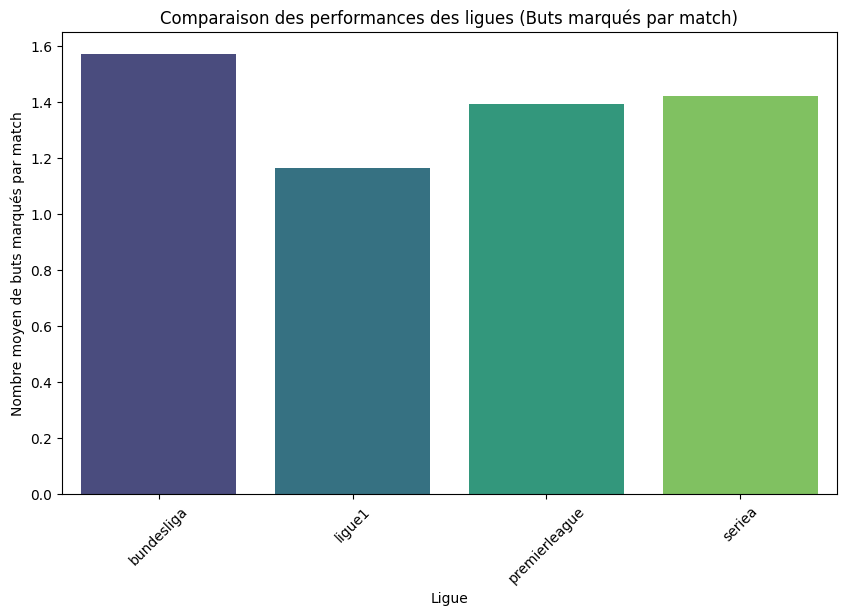

In [27]:

# Calcul du nombre moyen de buts marqués par match pour chaque ligue
avg_goals_per_game = combined_df.groupby('league')['goals_per_game'].mean().reset_index()

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(x='league', y='goals_per_game', data=avg_goals_per_game, palette='viridis')
plt.xlabel('Ligue')
plt.ylabel('Nombre moyen de buts marqués par match')
plt.title('Comparaison des performances des ligues (Buts marqués par match)')
plt.xticks(rotation=45)
plt.show()


<ipython-input-28-9213742ee8ed>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='league', y='win_percentage', data=avg_win_percentage, palette='magma')


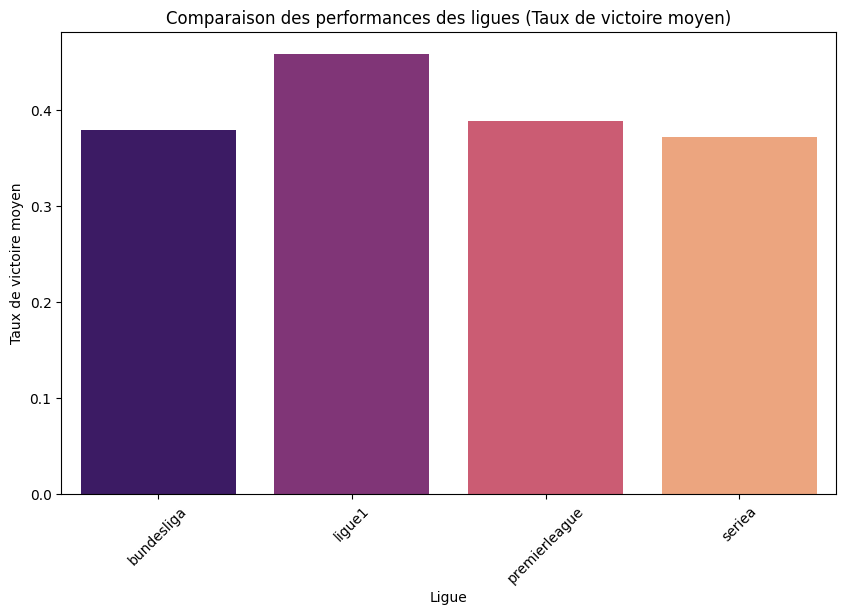

In [28]:
# Calcul du taux de victoire moyen pour chaque ligue
avg_win_percentage = combined_df.groupby('league')['win_percentage'].mean().reset_index()

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(x='league', y='win_percentage', data=avg_win_percentage, palette='magma')
plt.xlabel('Ligue')
plt.ylabel('Taux de victoire moyen')
plt.title('Comparaison des performances des ligues (Taux de victoire moyen)')
plt.xticks(rotation=45)
plt.show()


<ipython-input-29-1e2270c33097>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='league', y='goal_diff', data=combined_df, palette='Set3')


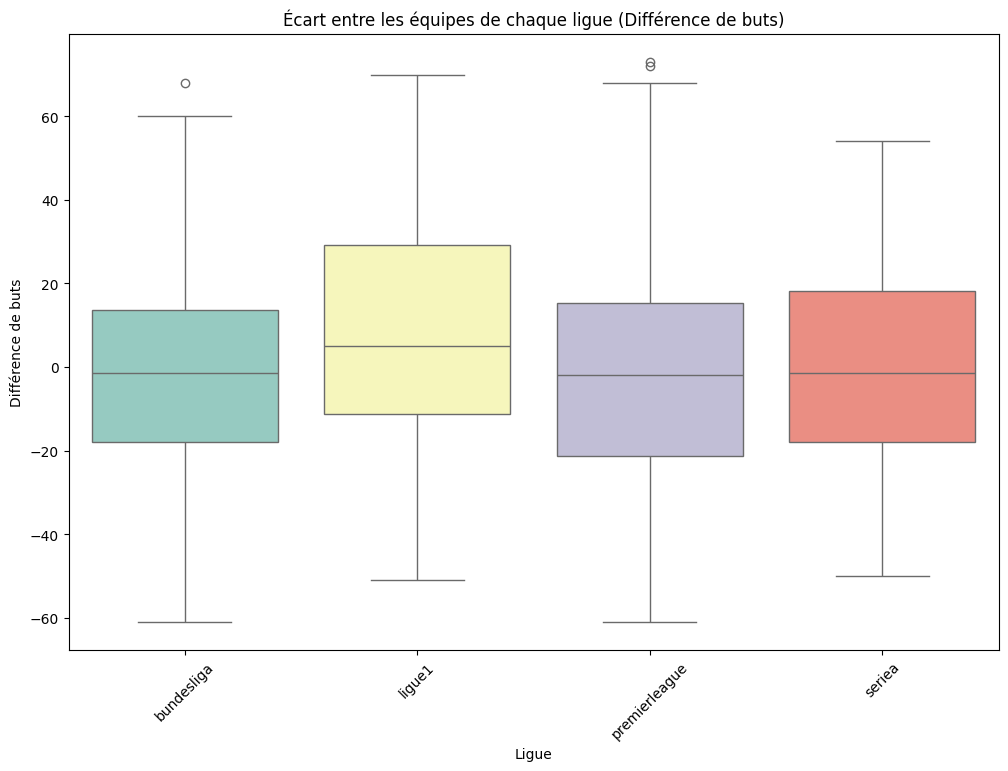

In [29]:


# Définition de la taille de la figure
plt.figure(figsize=(12, 8))

# Création d'un diagramme en boîte pour chaque ligue
sns.boxplot(x='league', y='goal_diff', data=combined_df, palette='Set3')
plt.xlabel('Ligue')
plt.ylabel('Différence de buts')
plt.title("Écart entre les équipes de chaque ligue (Différence de buts)")
plt.xticks(rotation=45)
plt.show()


# Feature engineering

In [30]:
label_encoder = LabelEncoder()
combined_df['team'] = label_encoder.fit_transform(combined_df['team'])

categorical_cols = ['league', 'team']
numeric_cols = ['point', 'played', 'won', 'drawn', 'lost', 'goal_scored', 'goal_conceded', 'goal_diff',
                'win_percentage', 'loss_percentage', 'goals_per_game', 'goals_against_per_game']

one_hot_encoder = OneHotEncoder(sparse=False)
combined_df_encoded = one_hot_encoder.fit_transform(combined_df[categorical_cols])

scaler = StandardScaler()
combined_df_numeric = scaler.fit_transform(combined_df[numeric_cols])

X = np.concatenate([combined_df_encoded, combined_df_numeric], axis=1)

# Define the target variable
league_rankings = {'premierleague': 1, 'bundesliga': 2, 'seriea': 3, 'ligue1': 4}
combined_df['league_rank'] = combined_df['league'].map(league_rankings)

# Split the data into features and target
X = combined_df.drop(['league', 'league_rank'], axis=1)
y = combined_df['league_rank']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres:", grid_search.best_params_)
print("Meilleur score de validation croisée:", -grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

predicted_league_rankings = {1: 'premierleague', 2: 'bundesliga', 3: 'seriea', 4: 'ligue1'}
predicted_league = predicted_league_rankings[int(round(y_pred.mean()))]
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")
print("La meilleure ligue est :", predicted_league)

print("Y pred mean :", y_pred.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Meilleurs hyperparamètres: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score de validation croisée: 0.8272751659156852
Mean Squared Error: 0.58
R-squared: 0.50
La meilleure ligue est : bundesliga
Y pred mean : 2.4322435897435892
